# K-nearest neighbor algorithm from scratch

In [132]:
#import libraries
from math import sqrt
from random import randrange
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import KFold
import numpy as np
from collections import Counter
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import MinMaxScaler

In [133]:
class KNN_classifier:


    def __init__(self, k_neighbors, folds = 5, normalize = False):
        '''
        Args:
            k_neighbors (int): number of nearest neighbors
            folds (int): number of folds for cross-validation training
        Returns:
            None
        '''

        self.k_neighbors = k_neighbors
        self.folds = folds
        self.normalize = normalize
        self.dataset = None
        self.classes = None

        #get iris dataset and normalize data if normalize = True
        self.initialize()

        
    def initialize(self):

        self.X, self.y = self.get_dataset()
        if self.normalize:
            X = self.normalize(X)
        self.classes = np.unique(self.y)
     

    def get_dataset(self):
        
        '''
        Args:
            path (str): path to dataset file
        Returns:
            dataset (list): dataset
        '''

        # Load Iris Dataset
        iris = datasets.load_iris()
        X = iris.data      

        y = iris.target

        return X, y
    
    def normalize_data(self, X):   
        '''
        Args:
            X (array): numpy array containing the dataset
        Returns:
            X (array): Normalized array
        '''      

        X = MinMaxScaler().fit_transform(X)

        return X
    
    # Calculate accuracy percentage
    def accuracy_metric(self, gt_label, predicted):
        correct = 0
        for i in range(len(gt_label)):
            if gt_label[i] == predicted[i]:
                correct += 1
        return correct / float(len(gt_label)) * 100.0
        
    

    #Split a dataset into k folds
    def cross_validation_split(self, X, y, n_folds):

        '''
        Args:
            X (array): training dataset
            y (array): class labels
            n_folds (int): number of K folds for cross validation

        Returns:        
            X_split (array): returns K valdiation folds
        '''

        X_split = list()
        X_copy = list(X)
        
        # Determine the number of samples in each fold
        fold_size = int(len(X) / n_folds)
        
        for _ in range(n_folds):
            
            fold = list()
            
            while len(fold) < fold_size:

                index = randrange(len(X_copy))
                #append item to fold while deleting it fromX_copy
                fold.append(X_copy.pop(index))
            
            X_split.append(fold)
        
        return X_split
    
    def euclidean_distance(self, a,b):
        '''
        Args: 
            a (vector): vector containing the features of sample a
            b (vector): vector contraining the features of sample b
        Returns:
            euclidean distance between a and b
        '''
        d = 0.0
        for i in range(len(a)):
            d += (a[i] - b[i])**2
        return sqrt(d)


    
    def get_class_prediction(self, distances, y):
        """
        Args:
            distances (array): distances of the k nearest neighbors
            y (array): labels of the k nearest neighbors
        Returns:
            y_pred_i (int): predicted class label obtained by majority voting
        """
        
        most_common = Counter(y).most_common(1)[0]
        y_pred_i = most_common[0]
        
        #P(A) = #outcomes in A / #outcomes in sample Space
        #y_pred_proba_i = most_common[1] / len(y)

        return y_pred_i

    
    def get_NN(self, X_train, y_train, test_sample):
        '''
        Args: 
            X (array): training dataset
            test_sample (array): new test sample
            n_neighbors (int): the number of K neighbors that should be returned
        Returns:
            neighbors (array): the K nearest neighbors
        '''
        # generate a list that stores all distance
        all_distances = [] 
        
        #Loop over all training examples
        for sample, label in zip(X_train, y_train):
            #compute the distance between a training sample an the new test sample
            distance = self.euclidean_distance(test_sample, sample)
            all_distances.append((sample, distance, label))
        
        #Sort the list using the second item as a key
        all_distances.sort(key = lambda a: a[1])

       
        # generate a list to store the neighbors
        neighbors, distances, labels = zip(*([(tp[0], tp[1], tp[2]) for tp in all_distances]))

        #return the k nearest neighbors
        return neighbors[: self.k_neighbors], distances[: self.k_neighbors], labels[: self.k_neighbors]

    def predict(self, X_train, y_train, test_sample):
        '''
        Args: 
            X (array): training dataset
            test_sample (array): new test sample
            n_neighbors (int): the number of K neighbors that should be returned
        Returns:
            prediction (int): predicted class label
        '''
        nearest_neighbors, distances, y = self.get_NN(X_train, y_train, test_sample)

        most_common = Counter(y).most_common(1)[0]
        
        y_pred_i = most_common[0]
               
        predicted_class = self.get_class_prediction(distances, y)
        
        return predicted_class
    
    # kNN Algorithm
    def k_nearest_neighbors(self, X_train, y_train, X_test):
        """
        Args:
            X_train (array) : training dataset
            y_train (array): training class labels
            X_test (array): test dataset           
        Returns:
            predictions (array): predicted class labels for the test dataset
        """
        predictions = list()
        for test_sample in X_test:
            output = self.predict(X_train, y_train, test_sample)
            predictions.append(output)
        return predictions
    

    # Evaluate an algorithm using a cross validation split
    def evaluate_algorithm(self):

        #visualize = False
      

        #legend  = ['Setosa', 'Versicolour', 'Virginica']
        

        scores = list()
        
        kf = KFold(n_splits=self.folds, random_state=None, shuffle=True)
        for train_index, test_index in kf.split(self.X):
            
            X_train, X_test = self.X[train_index], self.X[test_index]
            
            y_train, y_test = self.y[train_index], self.y[test_index]

           
            self.scatter_plot(self.X, self.y, X_train, y_train, X_test, y_test, self.k_neighbors)
            
            predicted = self.k_nearest_neighbors(X_train, y_train, X_test)
            
            accuracy = self.accuracy_metric(y_test, predicted)
            scores.append(accuracy)

        
        return scores
    
    # Scatter plot
    def scatter_plot(self, X, y, X_train, y_train, X_test, y_test, k, feature_idxs =[1,3] , h=0.05):
        
        legend  = ['Setosa', 'Versicolour', 'Virginica']

        feature_names = datasets.load_iris().feature_names

        xlbl, ylbl = feature_names[feature_idxs[0]], feature_names[feature_idxs[1]] 


        self.debug = False

        classes = list(set(y))
        cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
        colours = ['red', 'green', 'blue']
        pad = 0.5
        x_min, x_max = X[:, feature_idxs[0]].min() - pad, X[:, feature_idxs[0]].max() + pad
        y_min, y_max = X[:, feature_idxs[1]].min() - pad, X[:, feature_idxs[1]].max() + pad

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        
        X_train = X_train[:,[feature_idxs[0], feature_idxs[1]]]
        X_test = X_test[:,[feature_idxs[0], feature_idxs[1]]]

        mesh_testData = np.c_[xx.ravel(), yy.ravel()]
       
        Z =self.k_nearest_neighbors(X_train, y_train, mesh_testData)
        
        Z = np.array(Z).reshape(xx.shape)
        plt.figure(figsize=(8, 8))
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
        for i in classes:
            idx = np.where(y_train == classes[i])
            plt.scatter(X_train[idx, 0],
                        X_train[idx, 1],
                        c=colours[i],
                        label=legend[i],
                        marker='o', s=20)
        for i in classes:
            idx = np.where(y_test == classes[i])
            plt.scatter(X_test[idx, 0],
                        X_test[idx, 1],
                        c=colours[i],  # label=legend[i],
                        marker='x', s=20)
        plt.legend()
        plt.xlabel(xlbl, fontsize=16)
        plt.ylabel(ylbl, fontsize=16)
        plt.title("kNN classification (k = {}) - train (o), test (x)"
                .format(k), fontsize=16)
        plt.show()

        self.debug = False

             
     

    
      

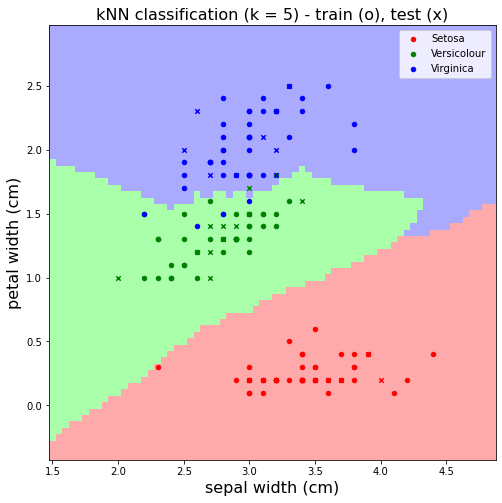

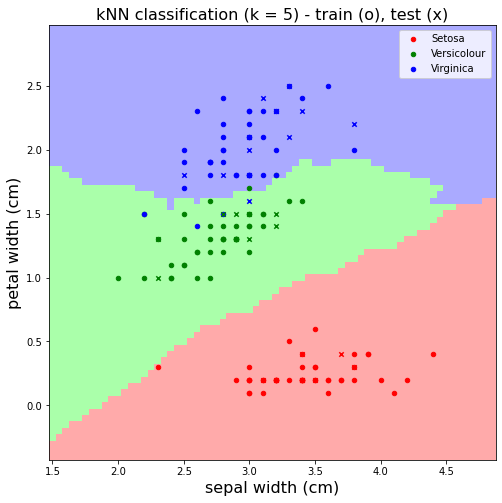

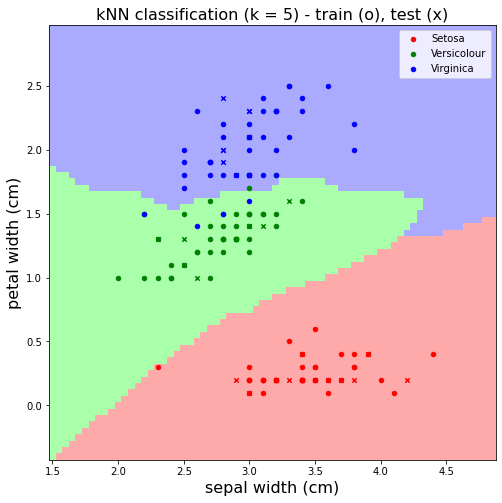

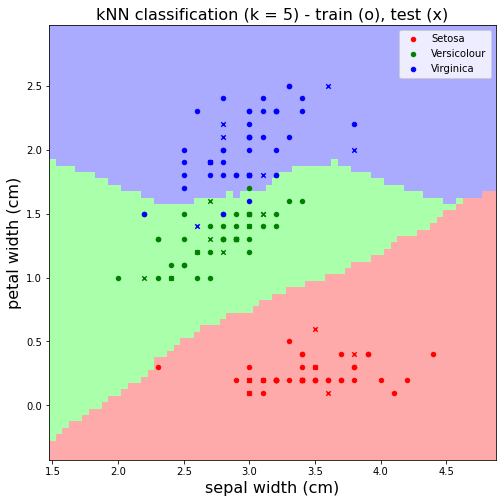

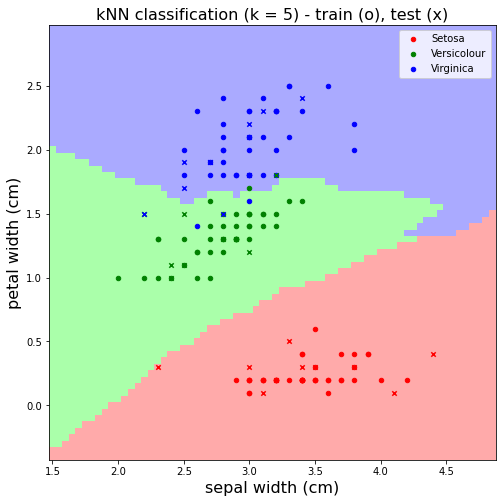

Scores: [100.0, 100.0, 100.0, 96.66666666666667, 93.33333333333333]
Mean Accuracy: 98.000%


In [134]:
# Test the kNN on the Iris Flowers dataset
num_neighbors = 5

knn = KNN_classifier(num_neighbors, folds = 5)


scores = knn.evaluate_algorithm()
#scores = evaluate_algorithm(dataset, k_nearest_neighbors, n_folds, num_neighbors)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))


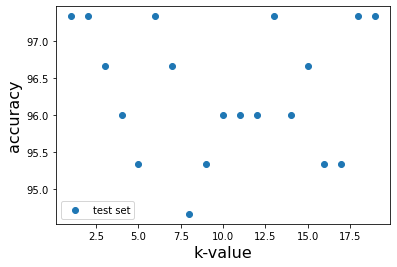

In [88]:
#Find best K
# Tune k
k_list, cross_validation_scores = [], []
for k in range(1, 20):
    knn = KNN_classifier(filename, num_neighbors, folds = 5)


    scores = knn.evaluate_algorithm()
    #scores = evaluate_algorithm(dataset, k_nearest_neighbors, n_folds, num_neighbors)
    k_list.append(k)
    cross_validation_scores.append(sum(scores)/float(len(scores)))

plt.scatter(k_list, cross_validation_scores, label='test set')
plt.xlabel('k-value', fontsize=16)
plt.ylabel('accuracy', fontsize=16)
#plt.ylim([0.5, 1.1])
plt.legend()
plt.show()
